## Load libraries

In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

from tensorflow.keras_vggface.vggface import VGGFace

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-e2oka2ho
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-e2oka2ho
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=b7b637dfb2d1b1721b6ffb41baeb9f7256c958a3031ae72796b6e9efd705a81c
  Stored in directory: /tmp/pip-ephem-wheel-cache-w8kqkzha/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface
     |████████████████████████████████| 50 kB 4.3 MB/s 


In [3]:
import pathlib # manipulate paths
import glob 
import os
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras_vggface.utils import preprocess_input

In [4]:
# Faster GPUs (only for Colab Pro)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep 26 16:07:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# More memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load paths and labels from the directory



In [7]:
# Now you can Unzip it!
# !unzip -q <SOURCE-PATH> -d <DESTINATION-PATH>

# !unzip -q /content/gdrive/MyDrive/DATASET/Face_Recognition/dataset.zip -d /content/gdrive/MyDrive/DATASET/Face_Recognition

In [8]:

PROJECT = pathlib.Path('/content/gdrive/MyDrive/DATASET/Face_Recognition')

# # SAVE RESULTS TO GDRIVE
# !mkdir -p /content/gdrive/MyDrive/DATASET/Face_Recognition/Result
# !mkdir -p /content/gdrive/MyDrive/DATASET/Face_Recognition/Saved_model

RESULT            = PROJECT/'Results'
SAVED_MODEL       = RESULT/'Saved_model'

IMG_SIZE = 224
BATCH_SIZE = 32

In [9]:
data_dir = PROJECT/'faces'

## Load and preprocess images


In [10]:
def generator_augmentation_maker():
  train_gen = ImageDataGenerator(
        # rescale = 1./255,
        rotation_range=45,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2) # IMPORTANT
  
  val_gen = ImageDataGenerator(validation_split=0.2
                              #  rescale = 1./255
                               )  # IMPORTANT

  train_generator = train_gen.flow_from_directory(
          data_dir,  
          target_size=(IMG_SIZE, IMG_SIZE),  
          batch_size=BATCH_SIZE,
          class_mode='categorical',
          shuffle=True,
          seed=42,            # IMPORTANT
          subset='training')  # IMPORTANT

  validation_generator = val_gen.flow_from_directory(
          data_dir,
          target_size=(IMG_SIZE, IMG_SIZE),
          batch_size=BATCH_SIZE,
          class_mode='categorical',
          shuffle=False,        # IMPORTANT
          seed=42,              # IMPORTANT
          subset='validation')  # IMPORTANT
  return train_generator, validation_generator

In [11]:
train_generator, validation_generator = generator_augmentation_maker()

Found 1929 images belonging to 4 classes.
Found 482 images belonging to 4 classes.


### Build model
First, let's defining the model!

In [12]:
# create a vggface model
base_model = VGGFace(model='resnet50', 
                include_top=False, 
                input_shape=(224, 224, 3), 
                pooling='avg')

94707712/94694792 [==============================] - 1s 0us/step


In [13]:
for layers in base_model.layers:
  layers.trainable = False

In [14]:
base_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [15]:
def layer_adder(bottom_model, num_classes):
  x = bottom_model.output
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)
  return x

In [16]:
num_classes = 4
head = layer_adder(base_model, num_classes)
model = Model(inputs = base_model.input, 
              outputs = head)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

### Train

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [19]:
callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)]
init_epochs=40

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=init_epochs,
                    callbacks = callback)

Epoch 1/40
61/61 [==============================] - 635s 10s/step - loss: 0.4706 - accuracy: 0.9264 - val_loss: 9.7323e-06 - val_accuracy: 1.0000
Epoch 2/40
61/61 [==============================] - 27s 445ms/step - loss: 0.0166 - accuracy: 0.9933 - val_loss: 6.5908e-06 - val_accuracy: 1.0000
Epoch 3/40
61/61 [==============================] - 27s 443ms/step - loss: 0.0140 - accuracy: 0.9948 - val_loss: 0.0102 - val_accuracy: 0.9959
Epoch 4/40
61/61 [==============================] - 27s 444ms/step - loss: 0.0060 - accuracy: 0.9969 - val_loss: 4.4303e-05 - val_accuracy: 1.0000
Epoch 5/40
61/61 [==============================] - 27s 441ms/step - loss: 0.0509 - accuracy: 0.9891 - val_loss: 0.0108 - val_accuracy: 0.9938
Epoch 6/40
61/61 [==============================] - 27s 441ms/step - loss: 0.0192 - accuracy: 0.9943 - val_loss: 3.4530e-06 - val_accuracy: 1.0000
Epoch 7/40
61/61 [==============================] - 27s 442ms/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 9.4379e-06 - v

In [20]:
model.evaluate(validation_generator)

16/16 [==============================] - 2s 98ms/step - loss: 2.1838e-07 - accuracy: 1.0000


[2.183811176337258e-07, 1.0]

In [21]:
def acc_loss_graph(history):
  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.legend()
  plt.title('Training and validation accuracy')

  plt.figure()
  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

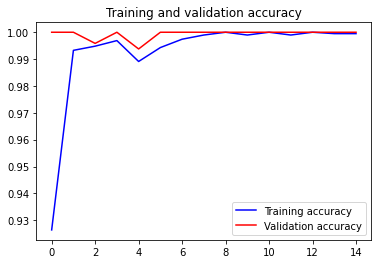

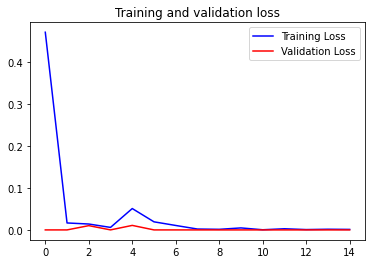

In [22]:
acc_loss_graph(history)

### Fine-tuning

Finally, let's unfreeze the last few more layers and train with a low learning rate.

In [23]:
# # Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  178


In [26]:
# # Unfreeze the base_model.
model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

# model.compile(loss = 'mean_squared_error',
#               optimizer = 'Adam',
#               metrics = ['MeanSquaredError',
#         'AUC',])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [27]:
# # CALLBACK and TRAIN

# # Stopped by EarlyStopping: model is auto-restored best weights => can CONTINUE to finetune
# # Stopped by user => LOAD model_ckpt to continue
# # Stopped by finishing => model saved to Saved_model
callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
            ModelCheckpoint(monitor='val_loss', filepath=RESULT/'face_recognition.h5', save_weights_only=False, save_best_only=True, verbose=1)]

init_epochs = 40
fine_tune_epochs = 15
total_epochs = init_epochs + fine_tune_epochs

history_fine = model.fit(train_generator, 
                         validation_data=validation_generator,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callbacks)

model.save(SAVED_MODEL)

Epoch 41/55
61/61 [==============================] - 34s 467ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 2.7852e-06 - val_accuracy: 1.0000

Epoch 00041: val_loss improved from inf to 0.00000, saving model to /content/gdrive/MyDrive/DATASET/Face_Recognition/Results/face_recognition.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/55
61/61 [==============================] - 28s 462ms/step - loss: 0.0113 - accuracy: 0.9984 - val_loss: 3.4784e-06 - val_accuracy: 1.0000

Epoch 00042: val_loss did not improve from 0.00000
Epoch 43/55
61/61 [==============================] - 28s 455ms/step - loss: 0.0205 - accuracy: 0.9969 - val_loss: 3.4345e-06 - val_accuracy: 1.0000

Epoch 00043: val_loss did not improve from 0.00000
Epoch 44/55
61/61 [==============================] - 28s 456ms/step - loss: 0.0083 - accuracy: 0.9974 - val_loss: 2.1022e-08 - val_accuracy: 1.0000

Epoch 00044: val_loss improved from 0.00000 to 0.00000, saving model to /content/gdrive/MyDrive/DATASET/Face_Recognition/Results/face_recognition.h5
Epoch 45/55
61/61 [==============================] - 28s 463ms/step - loss: 0.0163 - accuracy: 0.9969 - val_loss: 3.9191e-05 - val_accuracy: 1.0000

Epoch 00045: val_loss did not improve from 0.00000
Epoch 46/55
61/61 [==============================] - 28s 453ms/step - loss: 0.0016 - accuracy: 0.9990 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


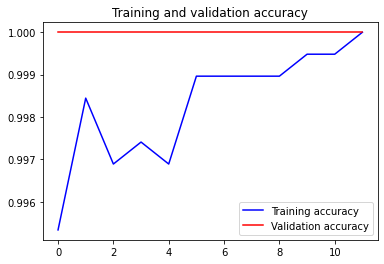

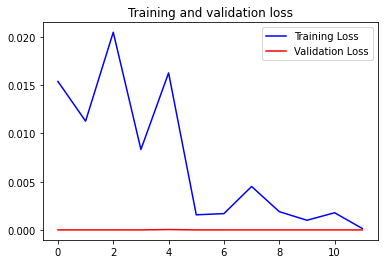

In [28]:
acc_loss_graph(history_fine)

## Load model

In [29]:
model = keras.models.load_model('/content/gdrive/MyDrive/DATASET/Face_Recognition/Results/face_recognition.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

## Predict a real image

Let's drag and drop a photo to your Colab folder and update the file name below.

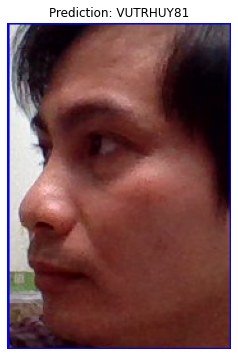

In [30]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model.predict(img)

  for key, value in validation_generator.class_indices.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

# TEST with your photo
image_path='/content/gdrive/MyDrive/DATASET/Face_Recognition/faces/Vutrhuy81/vutrhuy81_1_1y_275.jpg'
predict(model, image_path, IMG_SIZE)

Saving Duy_Test_17.jpg to Duy_Test_17.jpg


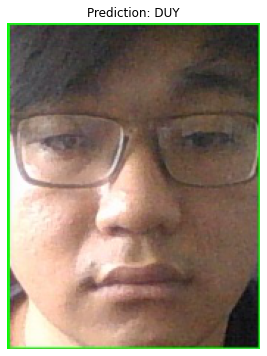

In [32]:
from google.colab import files
uploaded = files.upload()
path = '/content/' + list(uploaded.keys())[0]
predict(model, path, IMG_SIZE)